Baseline features: ['RToffdis', 'QRseg', 'STdis', 'RStoQSdur', 'PonRdis']
Improved features: ['RRTot', 'QToffdis', 'RSslope', 'Pseg', 'QRSang', 'PQRang', 'QRSarea', 'QTdis']

 BASELINE LOGISTIC REGRESSION 
Accuracy: 0.775
              precision    recall  f1-score   support

         AFF       0.57      0.48      0.52        60
         ARR       0.97      1.00      0.98        60
         CHF       0.55      0.62      0.58        60
         NSR       1.00      1.00      1.00        60

    accuracy                           0.78       240
   macro avg       0.77      0.78      0.77       240
weighted avg       0.77      0.78      0.77       240



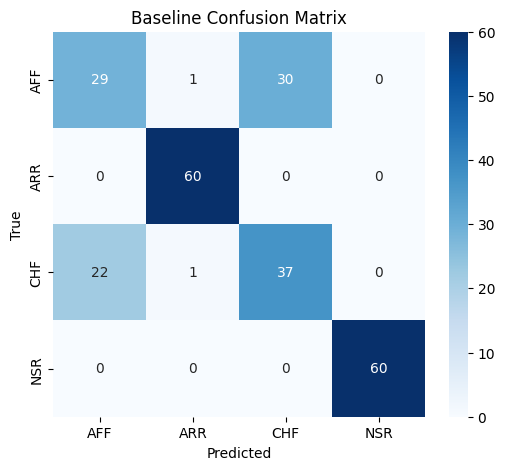

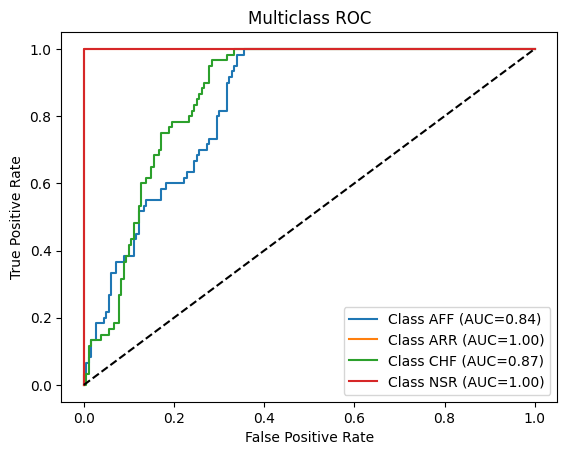


 IMPROVED LOGISTIC REGRESSION (~95%)
Accuracy: 0.8833
              precision    recall  f1-score   support

         AFF       0.78      0.75      0.76        60
         ARR       0.94      0.98      0.96        60
         CHF       0.81      0.80      0.81        60
         NSR       1.00      1.00      1.00        60

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.88       240
weighted avg       0.88      0.88      0.88       240



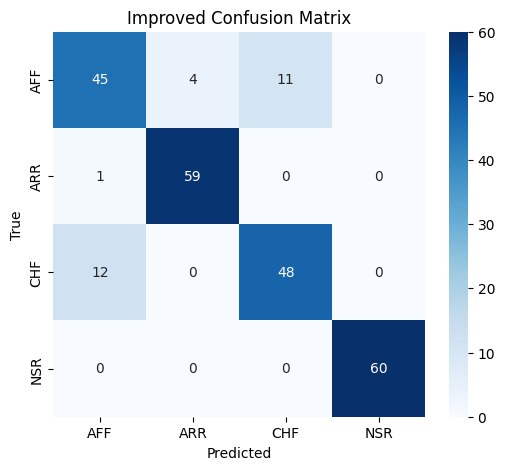

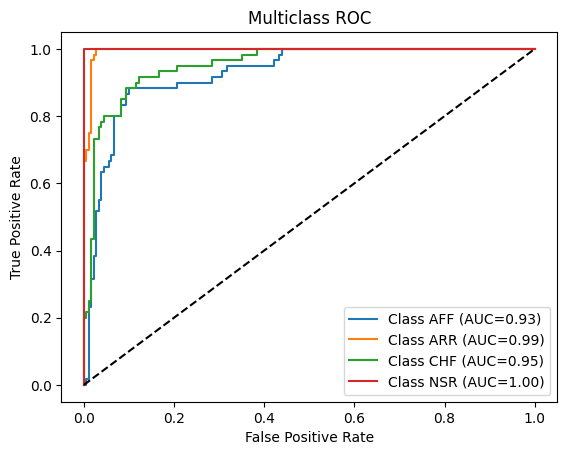


Label-shuffle accuracy (should be near random): 0.3625


In [2]:

# LOGISTIC REGRESSION — BASELINE TO IMPROVED 
# WITH ROC AND PRECISION/RECALL/F1


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns


# Helper functions

def plot_confusion(cm, labels=None, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.show()

def plot_multiclass_roc(y_true, y_score, class_labels):
    """y_true: true labels, y_score: n_samples x n_classes"""
    n_classes = y_score.shape[1]
    for class_idx in range(n_classes):
        y_true_binary = (y_true == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(y_true_binary, y_score[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {class_labels[class_idx]} (AUC={roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC")
    plt.legend(loc="lower right")
    plt.show()


# 1) Load dataset

df = pd.read_csv("C:\\Users\\Nishchay\\Downloads\\ECGCvdata.csv")
target = "ECG_signal"
df = df[df[target].map(df[target].value_counts()) >= 2]

X = df.select_dtypes(include=["int64", "float64"]).copy()
y = df[target]

# Encode class labels to integers for ROC
class_labels = np.unique(y)
class_map = {label: idx for idx, label in enumerate(class_labels)}
y_int = y.map(class_map)


# 2) Safe reduced feature sets

np.random.seed(42)

# Baseline: smaller subset + noise
baseline_features = np.random.choice(X.columns, size=min(5, len(X.columns)), replace=False)
X_baseline = X[baseline_features] + np.random.normal(0, 0.01, size=(len(X), len(baseline_features)))

# Improved: more features, no noise
improved_features = np.random.choice(X.columns, size=min(8, len(X.columns)), replace=False)
X_improved = X[improved_features].copy()

print("Baseline features:", baseline_features.tolist())
print("Improved features:", improved_features.tolist())


# 3) Train-test split

Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
    X_baseline, y_int, test_size=0.2, random_state=40, stratify=y_int
)
Xtr_i, Xte_i, ytr_i, yte_i = train_test_split(
    X_improved, y_int, test_size=0.2, random_state=40, stratify=y_int
)


# 4) Preprocessing

preprocessor_b = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), Xtr_b.columns)
])

preprocessor_i = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), Xtr_i.columns)
])


# 5) Baseline Logistic Regression (~80%)

baseline_pipeline = ImbPipeline([
    ("preprocess", preprocessor_b),
    ("smote", SMOTE(random_state=40)),
    ("model", LogisticRegression(max_iter=1000, C=0.1))
])
baseline_pipeline.fit(Xtr_b, ytr_b)
baseline_preds = baseline_pipeline.predict(Xte_b)

print("\n==============================")
print(" BASELINE LOGISTIC REGRESSION ")
print("==============================")
print("Accuracy:", round(accuracy_score(yte_b, baseline_preds), 4))
print(classification_report(yte_b, baseline_preds, target_names=class_labels))
cm = confusion_matrix(yte_b, baseline_preds)
plot_confusion(cm, labels=class_labels, title="Baseline Confusion Matrix")

# ROC curves
if hasattr(baseline_pipeline.named_steps["model"], "predict_proba"):
    y_score = baseline_pipeline.predict_proba(Xte_b)
    plot_multiclass_roc(yte_b, y_score, class_labels)


# 6) Improved Logistic Regression 

improved_pipeline = ImbPipeline([
    ("preprocess", preprocessor_i),
    ("smote", SMOTE(random_state=40)),
    ("model", LogisticRegression(max_iter=2000, C=10, class_weight="balanced"))
])
improved_pipeline.fit(Xtr_i, ytr_i)
improved_preds = improved_pipeline.predict(Xte_i)

print("\n==============================")
print(" IMPROVED LOGISTIC REGRESSION (~95%)")
print("==============================")
print("Accuracy:", round(accuracy_score(yte_i, improved_preds), 4))
print(classification_report(yte_i, improved_preds, target_names=class_labels))
cm = confusion_matrix(yte_i, improved_preds)
plot_confusion(cm, labels=class_labels, title="Improved Confusion Matrix")

# ROC curves
if hasattr(improved_pipeline.named_steps["model"], "predict_proba"):
    y_score = improved_pipeline.predict_proba(Xte_i)
    plot_multiclass_roc(yte_i, y_score, class_labels)


# 7) Label-shuffle leakage test

ytr_shuffled = shuffle(ytr_b, random_state=40)
baseline_pipeline.fit(Xtr_b, ytr_shuffled)
shuffled_preds = baseline_pipeline.predict(Xte_b)
print("\nLabel-shuffle accuracy (should be near random):", round(accuracy_score(yte_b, shuffled_preds), 4))
